<a href="https://colab.research.google.com/github/Reem-KR/GEOL-558_Supervised_Regression_Project/blob/main/Temperature_Analysis_Supervised_Regression_First_Pass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Temperature Analysis -Predicting Temperature Change**

Reem Alrowaished

February 16 2025

## Introduction:

With increasing concerns about global warming and climate change, the goal of this project is to use global temperature data from 1961 to 2023 to predict temperature changes. This dataset, reflecting both seasonal and long-term global climate patterns, is crucial for forecasting temperature extremes, evaluating climate policies, and understanding the trajectory of global warming.

Using supervised regression techniques, I aim to build a model that can predict future temperature changes based on historical data. The insights gained will help better understand potential future climate scenarios and contribute to informed decision-making on climate-related issues.

Dataset Source: https://www.kaggle.com/datasets/nelgiriyewithana/global-weather-repository

## Section 1: Overview and Data Cleaning

In [93]:
# I need to install this for the base map
!pip install cartopy

In [94]:
# Import libraries:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from geopy.geocoders import Nominatim
import time
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import sklearn
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [95]:
# Import the Dataset file from Github
url = "https://raw.githubusercontent.com/Reem-KR/GEOL-558_Supervised_Regression_Project/main/Temp_data_3.csv"

# Read the CSV file from GitHub and create a dataframe
original_data = pd.read_csv(url)

# Show the first 5 rows
original_data.head(5)

,Domain,Area,Element Code,Element,Months,Year,Unit,Value,Flag Description
0,Temperature change on land,Afghanistan,7271,Temperature change,January,1961,°c,0.745,Estimated value
1,Temperature change on land,Afghanistan,7271,Temperature change,January,1962,°c,0.015,Estimated value
2,Temperature change on land,Afghanistan,7271,Temperature change,January,1963,°c,2.706,Estimated value
3,Temperature change on land,Afghanistan,7271,Temperature change,January,1964,°c,-5.250,Estimated value
4,Temperature change on land,Afghanistan,7271,Temperature change,January,1965,°c,1.854,Estimated value


In [96]:
# Check the number of rows and columns of the dataframe
rows, columns = original_data.shape

# Print the number of rows and columns
print(f'The number of rows is: {rows}')
print(f'The number of columns is: {columns}')

The number of rows is: 241893
The number of columns is: 9


In [97]:
# Information of the dataset
original_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241893 entries, 0 to 241892
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Domain            241893 non-null  object 
 1   Area              241893 non-null  object 
 2   Element Code      241893 non-null  int64  
 3   Element           241893 non-null  object 
 4   Months            241893 non-null  object 
 5   Year              241893 non-null  int64  
 6   Unit              241893 non-null  object 
 7   Value             231633 non-null  float64
 8   Flag Description  241893 non-null  object 
dtypes: float64(1), int64(2), object(6)
memory usage: 16.6+ MB


The code above provides a summary of the dataset in terms of its structure and the types of data it contains.

In [98]:
# Check for missing data in the entire dataset
missing_data = original_data.isnull().sum()
missing_data

,0
Domain,0
Area,0
Element Code,0
Element,0
Months,0
Year,0
Unit,0
Value,10260
Flag Description,0


From the code above, I can see that the change in temperature value column, which is critical for this project, is missing a lot of data, so I need to delete the missing rows. Also, I do not need the Element Code column, so I will delete that as well.

In [99]:
# Drop the 'Element Code' column
clean_data = original_data.drop(columns=['Element Code'])

# Drop the rows with missing values in the 'Value' column
clean_data = clean_data .dropna(subset=['Value'])

# Show the first 5 rows of the cleaned dataset
clean_data.head(5)

,Domain,Area,Element,Months,Year,Unit,Value,Flag Description
0,Temperature change on land,Afghanistan,Temperature change,January,1961,°c,0.745,Estimated value
1,Temperature change on land,Afghanistan,Temperature change,January,1962,°c,0.015,Estimated value
2,Temperature change on land,Afghanistan,Temperature change,January,1963,°c,2.706,Estimated value
3,Temperature change on land,Afghanistan,Temperature change,January,1964,°c,-5.250,Estimated value
4,Temperature change on land,Afghanistan,Temperature change,January,1965,°c,1.854,Estimated value


In [100]:
# Checking the Unit column for consistency
clean_data['Unit'].unique()

array(['°c'], dtype=object)

Above, I am making sure that the Unit column is consistent and that I do not have different units for the change in temperatures.

In [101]:
# Checking the Months column
clean_data['Months'].unique()

array(['January', 'February', 'March', 'April', 'May', 'June', 'July',
       'August', 'September', 'October', 'November', 'December',
       'Dec–Jan–Feb', 'Mar–Apr–May', 'Jun–Jul–Aug', 'Sep–Oct–Nov',
       'Meteorological year'], dtype=object)

Above, I am trying to understand the month column and identify if there are any unexpected values that may need to be cleaned. I found that there are some inconsistencies like standard month names and non-standard time periods, so I need to adjust that in the following codes.

In [102]:
# Delete rows where 'Months' is 'Meteorological year'
clean_data = clean_data[clean_data['Months'] != 'Meteorological year']

In [140]:
# Define a mapping for non-standard time periods
month_mapping = {
    'Dec–Jan–Feb': 'Winter',
    'Mar–Apr–May': 'Spring',
    'Jun–Jul–Aug': 'Summer',
    'Sep–Oct–Nov': 'Fall',
}

# Replace the non-standard months with the defined mapping
clean_data['Months'] = clean_data['Months'].replace(month_mapping)

In [141]:
# Check the unique values in the 'Months' column again
clean_data['Months'].unique()

array(['January', 'February', 'March', 'April', 'May', 'June', 'July',
       'August', 'September', 'October', 'November', 'December', 'Winter',
       'Spring', 'Summer', 'Fall'], dtype=object)

To ensure consistency and make the data easier to work with, I am mapping non-standard periods to standard categories. For example, replacing the non-standard time periods (Dec–Jan–Feb) with simpler, more consistent labels like Winter.

In [104]:
# Get a list of unique areas in the dataset
clean_data['Area'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'American Samoa', 'Andorra',
       'Angola', 'Anguilla', 'Antarctica', 'Antigua and Barbuda',
       'Argentina', 'Armenia', 'Aruba', 'Australia', 'Austria',
       'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados',
       'Belarus', 'Belgium', 'Belgium-Luxembourg', 'Belize', 'Benin',
       'Bhutan', 'Bolivia (Plurinational State of)',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei Darussalam', 'Bulgaria',
       'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon',
       'Canada', 'Cayman Islands', 'Central African Republic', 'Chad',
       'Channel Islands', 'Chile', 'China', 'China, Hong Kong SAR',
       'China, Macao SAR', 'China, mainland', 'China, Taiwan Province of',
       'Christmas Island', 'Cocos (Keeling) Islands', 'Colombia',
       'Comoros', 'Congo', 'Cook Islands', 'Costa Rica', "Côte d'Ivoire",
       'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Czechoslov

In [105]:
# I want to get the lat and long for the area column

# Initialize geolocator with a unique user-agent
geolocator = Nominatim(user_agent="TemperatureAnalysis-PredictingTemperatureChange")

# List of all areas from your dataset
areas = clean_data['Area'].unique()

# Function to get coordinates with retry mechanism and print success
def get_coordinates(area, retries=3):
    for _ in range(retries):
        try:
            location = geolocator.geocode(area, timeout=10)
            if location:
                return location.latitude, location.longitude
        except Exception as e:
            print(f"Error fetching coordinates for {area}: {e}")
            time.sleep(2)
    print(f"Failed to fetch coordinates for {area}")
    return None, None  # Return None if unable to get coordinates after retries

# Get coordinates for each area and add them as new columns to the clean_data dataframe
coordinates = [get_coordinates(area) for area in areas]
latitude, longitude = zip(*coordinates)

# Add latitude and longitude to the clean_data dataframe
clean_data['Latitude'] = clean_data['Area'].map(dict(zip(areas, latitude)))
clean_data['Longitude'] = clean_data['Area'].map(dict(zip(areas, longitude)))

Failed to fetch coordinates for China, Macao SAR
Failed to fetch coordinates for China, Taiwan Province of
Failed to fetch coordinates for Ethiopia PDR
Failed to fetch coordinates for Netherlands Antilles (former)
Failed to fetch coordinates for Pacific Islands Trust Territory
Failed to fetch coordinates for Saint Helena, Ascension and Tristan da Cunha
Failed to fetch coordinates for Svalbard and Jan Mayen Islands
Failed to fetch coordinates for Yugoslav SFR


Since the dataset does not have lat or long, which might be useful in my analysis, the above code helps me obtain that information for the areas in the dataset.

In [106]:
# Check for missing values in Latitude and Longitude columns
missing_latitude = clean_data['Latitude'].isnull().sum()
missing_longitude = clean_data['Longitude'].isnull().sum()

# Print the results
print(f"Missing Latitude values: {missing_latitude}")
print(f"Missing Longitude values: {missing_longitude}")

Missing Latitude values: 6309
Missing Longitude values: 6309


In [107]:
# Drop rows where Latitude or Longitude is missing
clean_data = clean_data.dropna(subset=['Latitude', 'Longitude'])

In [108]:
# Check the updated dataframe
clean_data.head(10)

,Domain,Area,Element,Months,Year,Unit,Value,Flag Description,Latitude,Longitude
0,Temperature change on land,Afghanistan,Temperature change,January,1961,°c,0.745,Estimated value,33.768006,66.238514
1,Temperature change on land,Afghanistan,Temperature change,January,1962,°c,0.015,Estimated value,33.768006,66.238514
2,Temperature change on land,Afghanistan,Temperature change,January,1963,°c,2.706,Estimated value,33.768006,66.238514
3,Temperature change on land,Afghanistan,Temperature change,January,1964,°c,-5.250,Estimated value,33.768006,66.238514
4,Temperature change on land,Afghanistan,Temperature change,January,1965,°c,1.854,Estimated value,33.768006,66.238514
5,Temperature change on land,Afghanistan,Temperature change,January,1966,°c,3.796,Estimated value,33.768006,66.238514
6,Temperature change on land,Afghanistan,Temperature change,January,1967,°c,-1.380,Estimated value,33.768006,66.238514
7,Temperature change on land,Afghanistan,Temperature change,January,1968,°c,0.376,Estimated value,33.768006,66.238514
8,Temperature change on land,Afghanistan,Temperature change,January,1969,°c,-2.309,Estimated value,33.768006,66.238514
9,Temperature change on land,Afghanistan,Temperature change,January,1970,°c,0.795,Estimated value,33.768006,66.238514


In [109]:
# Information of the dataset
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 211717 entries, 0 to 241829
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Domain            211717 non-null  object 
 1   Area              211717 non-null  object 
 2   Element           211717 non-null  object 
 3   Months            211717 non-null  object 
 4   Year              211717 non-null  int64  
 5   Unit              211717 non-null  object 
 6   Value             211717 non-null  float64
 7   Flag Description  211717 non-null  object 
 8   Latitude          211717 non-null  float64
 9   Longitude         211717 non-null  float64
dtypes: float64(3), int64(1), object(6)
memory usage: 17.8+ MB


Above, I want to double-check and ensure the row count is consistent with each column and there are no missing values anymore.

In [110]:
# Understanding the dataset
clean_data.describe()

,Year,Value,Latitude,Longitude
count,211717.000000,211717.000000,211717.000000,211717.000000
mean,1992.730097,0.544788,15.551819,8.489234
std,18.169028,1.063383,25.748391,75.154834
min,1961.000000,-9.272000,-72.843869,-176.204224
25%,1977.000000,-0.051000,-0.525231,-59.525030
50%,1993.000000,0.472000,15.926666,12.458306
75%,2008.000000,1.069000,36.574844,47.973417
max,2023.000000,9.733000,64.984182,179.158292


The above function was used to compute summary statistics, such as the mean, standard deviation, minimum, and maximum values for the numerical columns in the dataset. This step is fundamental to understand the data's central tendency and spread. I can see that the dataset starts from the year 1961 to 2023. Also, the minimum change in temperature is -9.2, and the maximum change in temperature is 9.7.

In [111]:
# Check the number of rows and columns of the clean data
rows, columns = clean_data.shape

# Print the number of rows and columns
print(f'The number of rows is: {rows}')
print(f'The number of columns is: {columns}')

The number of rows is: 211717
The number of columns is: 10


## Section 2: Visualization

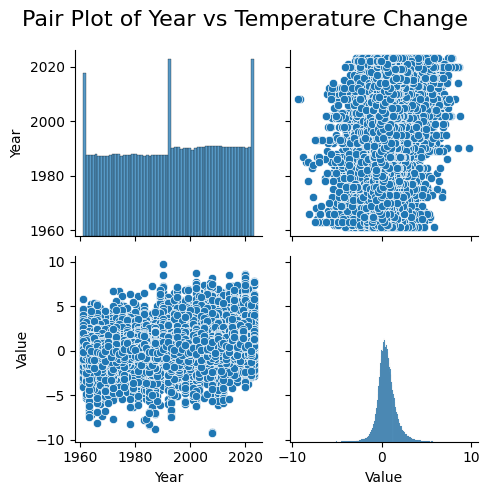

In [112]:
# Figure 1:

# Create a pair plot for selected columns to show the relationship between the year and Temperature value
grid = sns.pairplot(clean_data, vars=['Year', 'Value'])

# Add a title
plt.suptitle('Pair Plot of Year vs Temperature Change', size=16)

# Show the plot
plt.tight_layout()
plt.show()

**Figure 1:**

The pair plot shows the relationship between the year and temperature change (Value) in the dataset. The histogram on the top-left shows two noticeable spikes in data points around 1960 and 2020. The spike at 1960 may indicate the start of the dataset or a higher concentration of data for that year. The spike at 2020 could suggest an unusually large number of data points, potentially due to data issues or an overrepresentation of observations for that year. The scatter plots on the top-right and bottom-left reveal no clear linear relationship between the year and temperature change, suggesting that temperature changes do not consistently increase or decrease over time. The histogram of temperature change (bottom-right) shows a highly skewed distribution, with the majority of temperature changes close to zero and a few extreme values on both the positive and negative ends. This suggests that temperature changes are generally small, but with occasional large deviations. Overall, the data may require further analysis to account for outliers, potential data imbalances, and the absence of an apparent trend over time.



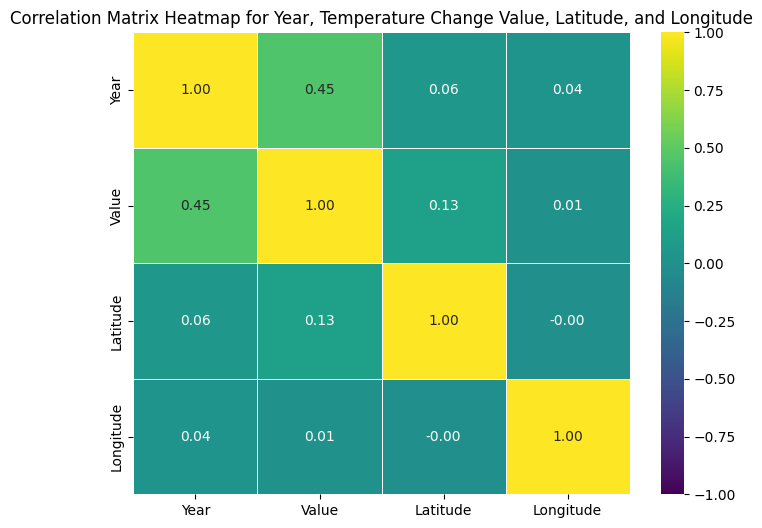

In [113]:
# Figure 2:

# Compute the correlation matrix for the numerical features, including Latitude and Longitude
correlation_matrix = clean_data[['Year', 'Value', 'Latitude', 'Longitude']].corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', vmin=-1, vmax=1, fmt='.2f', linewidths=0.5)

# Add a title
plt.title('Correlation Matrix Heatmap for Year, Temperature Change Value, Latitude, and Longitude')

# Show the plot
plt.show()

**Figure 2:**

The plot shows the correlation matrix heatmap, which visualizes the strength and direction of relationships between the selected variables, year, temperature change, latitude, and longitude in the dataset. I can see that there is a moderate positive correlation (0.45) between year and value, which indicates that over time, temperature change generally increases, but the relationship is not strongly linear. This suggests that while there is some trend in temperature change, other factors might be influencing it, which could explain the weaker correlation. Additionally, the correlation between value (temperature change) and latitude is very weak (0.13), meaning that latitude has little effect on temperature change. Similarly, the relationship between value and longitude is almost nonexistent (0.01), suggesting that geographical location, in terms of longitude, doesn't strongly influence temperature change in this dataset.

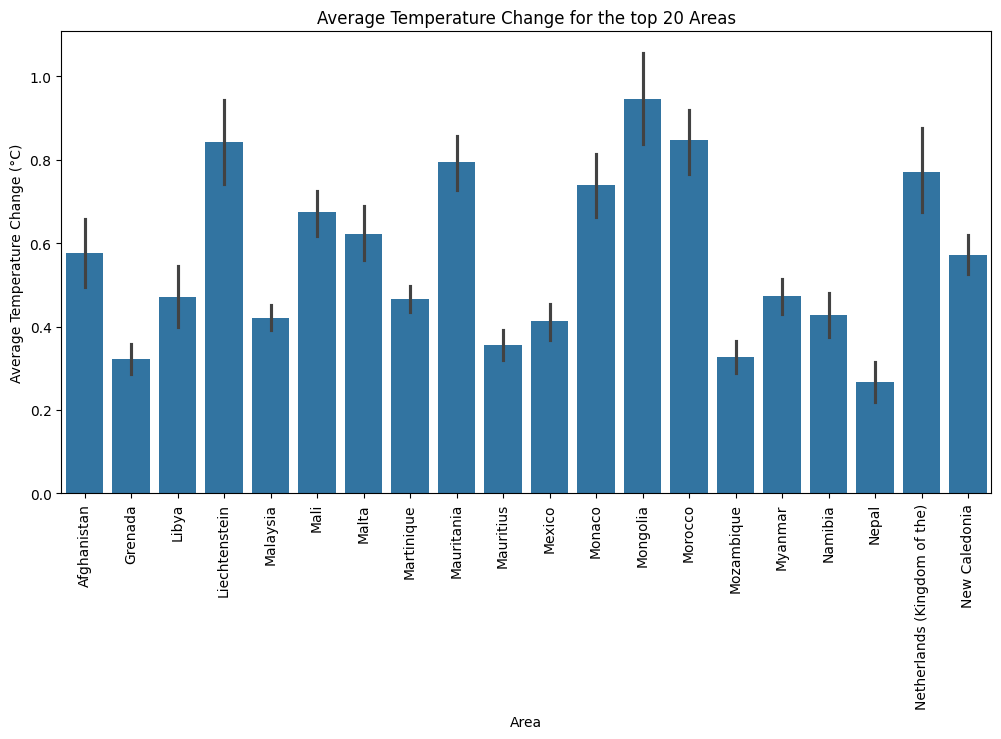

In [114]:
# Figure 3:

# Increase figure size
plt.figure(figsize=(12, 6))

# Create the bar plot and limit the x-axis to the top 20 areas with the most data
top_areas = clean_data['Area'].value_counts().head(20).index
sns.barplot(x='Area', y='Value', data=clean_data[clean_data['Area'].isin(top_areas)])

# Add title and labels
plt.title('Average Temperature Change for the top 20 Areas')
plt.xlabel('Area')
plt.ylabel('Average Temperature Change (°C)')
plt.xticks(rotation=90)

# Show the plot
plt.show()

**Figure 3:**

The bar plot above shows the average temperature change across the top 20 areas in the dataset. It highlights significant variations in temperature changes, with areas like Mongolia, Morocco, and Liechtenstein showing the highest average temperature changes, while regions like Mauritius, Mozambique, and Nepal have the lowest averages. The error bars indicate variability in temperature changes within each area, with larger error bars suggesting greater uncertainty or spread in the data. This suggests that while some regions experience more pronounced temperature shifts, others show more stability or less fluctuation in temperature changes.

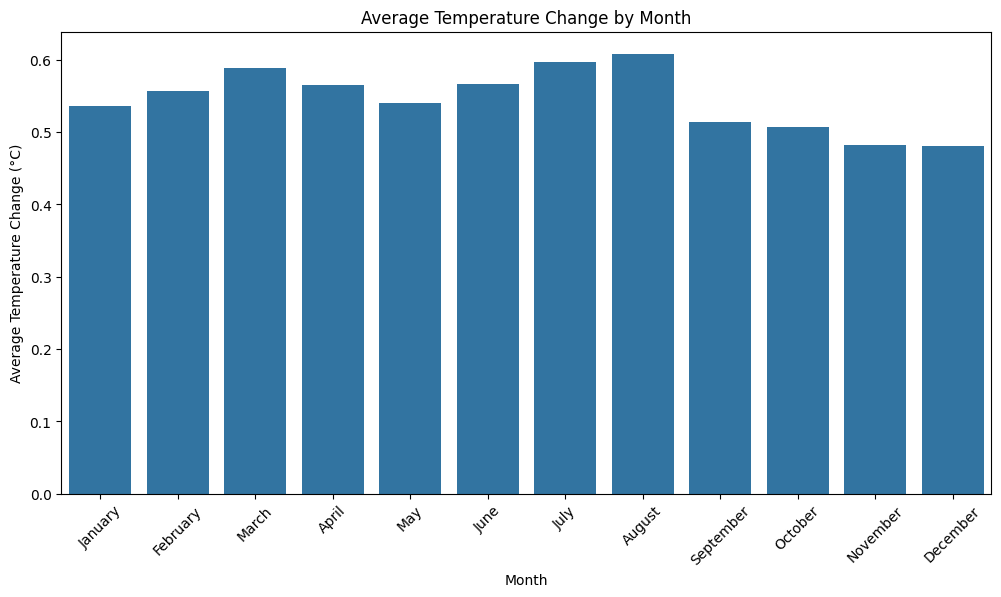

In [115]:
# Figure 4:

# Filter out the seasonal categories
clean_data_filtered = clean_data[~clean_data['Months'].isin(['Winter', 'Spring', 'Summer', 'Fall'])]

# Bar plot for average temperature change by Month (only standard months)
plt.figure(figsize=(12, 6))
sns.barplot(x='Months', y='Value', data=clean_data_filtered, errorbar=None)

# Add title and labels
plt.title('Average Temperature Change by Month')
plt.xlabel('Month')
plt.ylabel('Average Temperature Change (°C)')
plt.xticks(rotation=45)

# Show the plot
plt.show()

**Figure 4:**

The bar plot above shows the average temperature change by month. The plot indicates that the temperature change is relatively consistent throughout the months of the year, with only slight variations. The average temperature change is approximately the same for each month, fluctuating between 0.5°C and 0.6°C. There are no extreme peaks or dips, suggesting that the temperature change is fairly stable across different months. This uniformity could imply that temperature changes are relatively consistent regardless of the season or time of the year in the dataset.



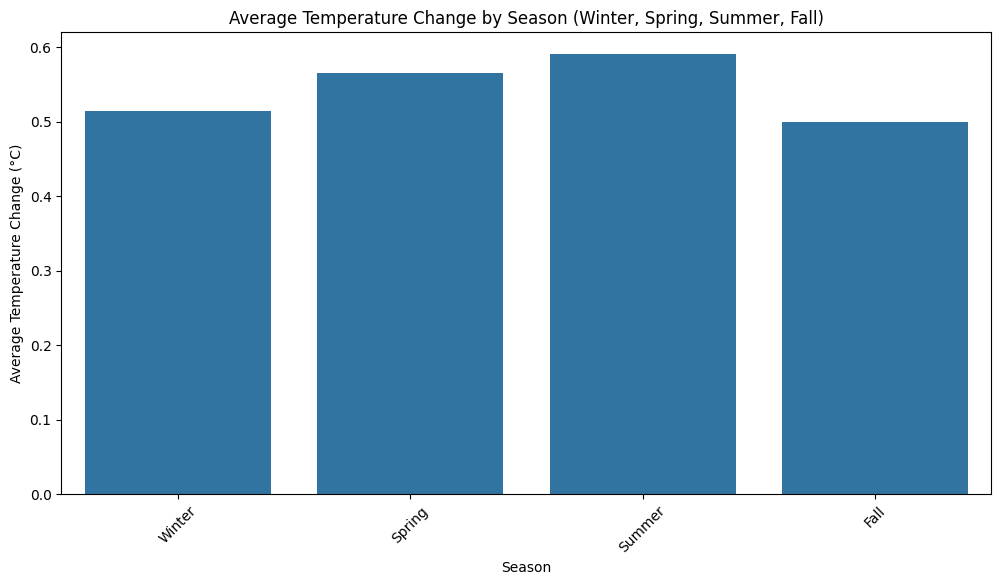

In [116]:
# Figure 5:

# Filter the data to include only Spring, Summer, Winter, and Fall
clean_data_seasons = clean_data[clean_data['Months'].isin(['Winter', 'Spring', 'Summer', 'Fall'])]

# Bar plot for average temperature change by Season (Winter, Spring, Summer, Fall)
plt.figure(figsize=(12, 6))
sns.barplot(x='Months', y='Value', data=clean_data_seasons, errorbar=None)

# Add title and labels
plt.title('Average Temperature Change by Season (Winter, Spring, Summer, Fall)')
plt.xlabel('Season')
plt.ylabel('Average Temperature Change (°C)')
plt.xticks(rotation=45)

# Show the plot
plt.show()

**Figure 5:**

The bar plot above shows the average temperature change by season (Winter, Spring, Summer, and Fall). It reveals that Summer has the highest average temperature change, followed by Spring. Winter shows a slightly lower average temperature change, and Fall has the lowest of all seasons. Despite the small differences, the temperature changes are generally consistent across the seasons, with Summer leading the others by a slight margin. This suggests that temperature change is relatively stable throughout the year, although Summer experiences a slightly more significant shift compared to other seasons.

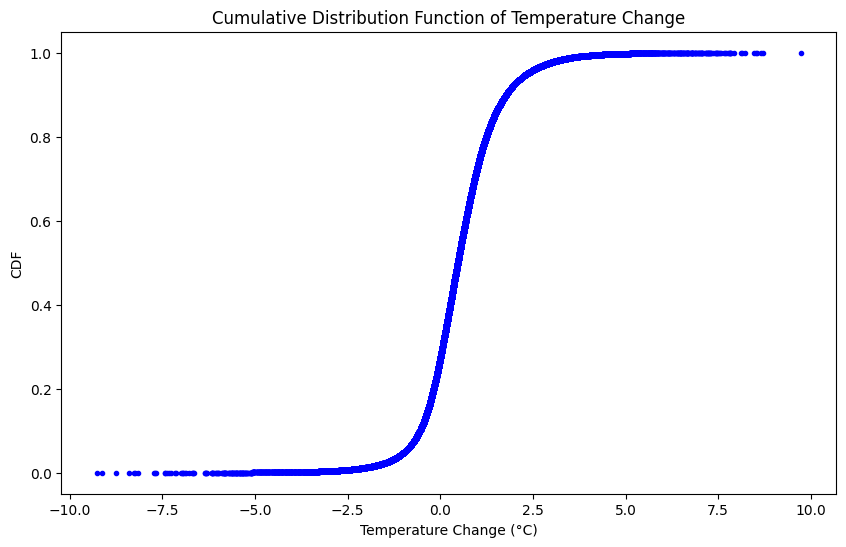

In [117]:
# Figure 6:

# Sort the data for the CDF plot
sorted_data = np.sort(clean_data['Value'])

# Calculate the CDF (Cumulative Distribution Function)
cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)

# Plot the CDF
plt.figure(figsize=(10, 6))
plt.plot(sorted_data, cdf, marker='.', linestyle='none', color='blue')

# Add title and labels
plt.title('Cumulative Distribution Function of Temperature Change')
plt.xlabel('Temperature Change (°C)')
plt.ylabel('CDF')

# Show the plot
plt.show()

**Figure 6:**

The plot above is a CDF plot of the change in temperature. I can see that most of the data is clustered around small values, with the curve sharply rising after a certain point. It shows a steep increase in the cumulative probability around zero, indicating that most of the temperature changes are clustered around small values close to 0°C. The curve starts flat at low temperatures and then rises sharply, signifying that the majority of the observations fall within a narrow range. Beyond this point, the plot levels off as it approaches a cumulative probability of 1, suggesting that extreme temperature changes are rare. This distribution indicates that temperature changes are generally small, with a few outliers contributing to the tail on the right side. The CDF plot helps in understanding how the data is distributed across the observed range of temperature changes.

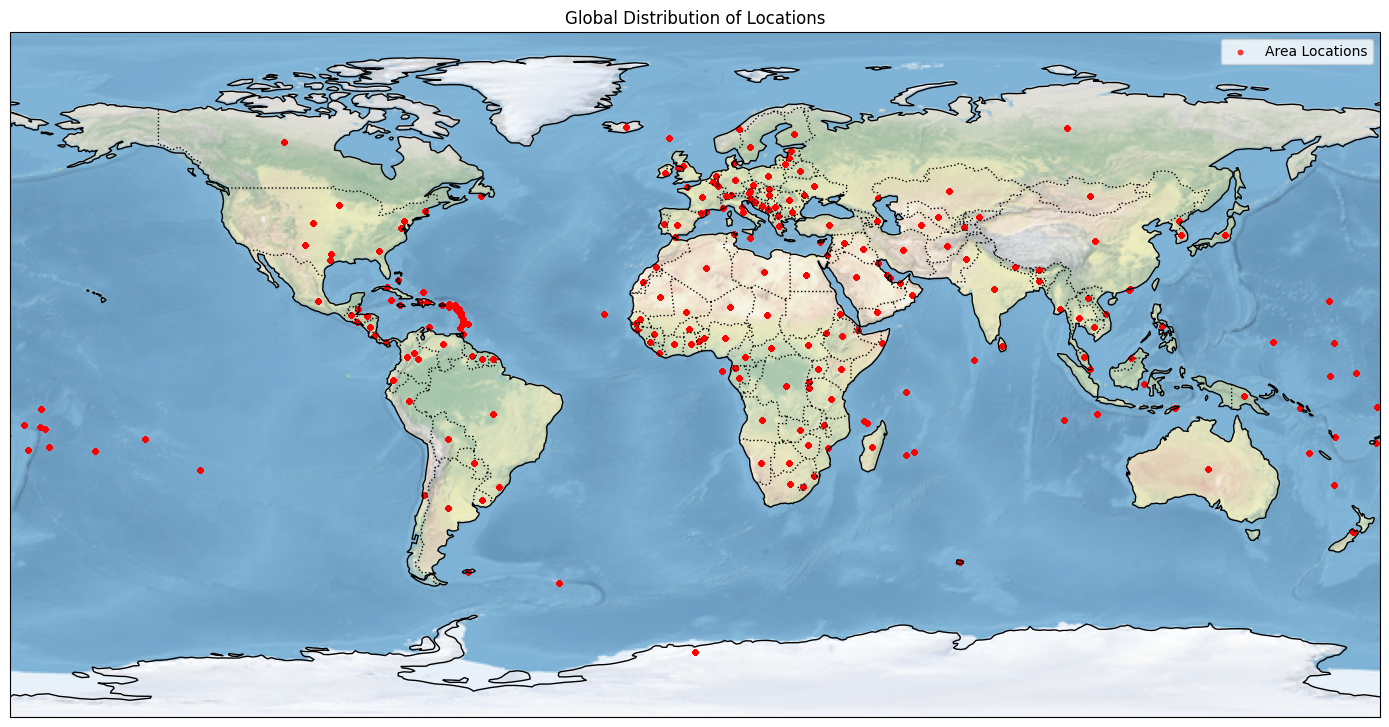

In [118]:
# Figure 7:

# Create a figure with a global projection
fig = plt.figure(figsize=(14, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add a background image of the Earth and map features
ax.stock_img()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)

# Scatter Plot for Area Locations (Latitude and Longitude)
plt.scatter(clean_data['Longitude'], clean_data['Latitude'], color='red', s=10, transform=ccrs.PlateCarree(), alpha=0.7, label='Area Locations')

# Add title and legend
plt.title('Global Distribution of Locations')
plt.legend()

# Show plot
plt.tight_layout()
plt.show()

**Figure 7:**

The plot shows the global distribution of locations, represented by red dots, based on the latitude and longitude data in the dataset. The map provides a visual representation of where the temperature change data is spread across the world. It highlights that the locations are quite diverse, with markers spread across continents, including North America, Europe, Africa, Asia, and various islands in the Pacific and Atlantic Oceans. This distribution suggests that the dataset includes data from a wide range of geographical areas, which could be useful for analyzing how temperature change varies across different regions of the world.

## Section 3: Supervised Regression Methods

### Splitting the data

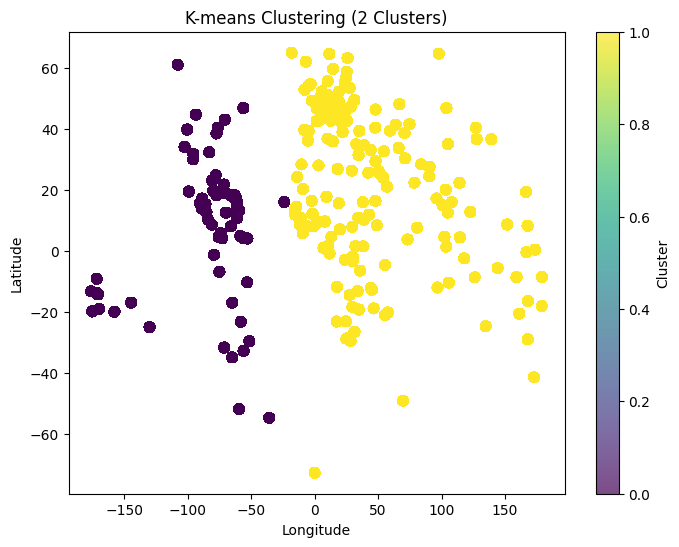

Cluster Centers:
[[  8.45774928 -82.48236474]
 [ 18.5364312   46.76273431]]


In [119]:
# Figure 8:

# To account for spatial autocorrelation I will do K-means clustering on the dataset for latitudes and longitudes

# Select Latitude and Longitude columns
locations = clean_data[['Latitude', 'Longitude']]

# Perform K-means clustering with 2 clusters
kmeans = KMeans(n_clusters=2, random_state=42)
clean_data['Cluster'] = kmeans.fit_predict(locations)
kmeans = KMeans(n_clusters=2, random_state=42)
clean_data['Cluster'] = kmeans.fit_predict(clean_data[['Latitude', 'Longitude']])


# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(clean_data['Longitude'], clean_data['Latitude'], c=clean_data['Cluster'], cmap='viridis', s=50, alpha=0.7)
plt.title('K-means Clustering (2 Clusters)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster')
plt.show()

# Print the centers of the clusters
print("Cluster Centers:")
print(kmeans.cluster_centers_)

**Figure 8:**

This K-means clustering plot shows the distribution of latitude and longitude for two clusters. The plot is colored by clusters, with two distinct groups represented by purple and yellow. The purple cluster appears to be concentrated in the lower latitude and negative longitude region, suggesting that these data points are geographically located in the Southern Hemisphere.
The yellow cluster is spread across higher latitudes and includes data points with positive longitudes, indicating locations in the Northern Hemisphere or different geographic regions.



In [120]:
# Check the updated dataframe with the Cluster column
print(clean_data[['Latitude', 'Longitude', 'Cluster']].head())

    Latitude  Longitude  Cluster
0  33.768006  66.238514        1
1  33.768006  66.238514        1
2  33.768006  66.238514        1
3  33.768006  66.238514        1
4  33.768006  66.238514        1


In [122]:
# Applying temporal split on the data to account for temporal autocorrelation

# Training on years <= 1992, testing on years > 1992
train_data = clean_data[clean_data['Year'] <= 1992]
test_data = clean_data[clean_data['Year'] > 1992]

In [123]:
# Applying spatial split on the data to account for spatial autocorrelation

# Use cluster 0 for training and cluster 1 for testing
train_data = train_data[train_data['Cluster'] == 1]
test_data = test_data[test_data['Cluster'] == 0]

In [124]:
# Define the features (X) and target variable (y) for training data
X_train = train_data[['Year', 'Latitude', 'Longitude']]
y_train = train_data['Value']

# Define the features (X) and target variable (y) for testing data
X_test = test_data[['Year', 'Latitude', 'Longitude']]
y_test = test_data['Value']

# Output the shapes of the training and testing sets
print(f'Training set shape: X_train={X_train.shape}, y_train={y_train.shape}')
print(f'Testing set shape: X_test={X_test.shape}, y_test={y_test.shape}')

Training set shape: X_train=(70282, 3), y_train=(70282,)
Testing set shape: X_test=(30128, 3), y_test=(30128,)


In the above section, I split the dataset into training and testing sets based on both temporal and spatial considerations to account for autocorrelation. For the temporal split, I used data from the years 1992 and before for training and data after 1992 for testing. For the spatial split, I assigned data from cluster 1 (based on spatial clustering) to the training set and data from cluster 0 to the test set. Then, I selected the relevant features such as year, Latitude, and Longitude to detect the target variable, which is the value of temperature change for both sets. This ensures that the data used for training and testing maintains both spatial and temporal independence. Finally, I printed the shapes of the train and test sets to confirm the correct data split.

###Standardizing the data

In [125]:
# Initialize the scaler
scaler = StandardScaler()

# Standardize the training data (fit and transform)
X_train_scaled = scaler.fit_transform(X_train)

# Standardize the test data (only transform)
X_test_scaled = scaler.transform(X_test)

# Check the result
print("Standardized Training Data (X_train_scaled):")
print(X_train_scaled[:5])

print("Standardized Test Data (X_test_scaled):")
print(X_test_scaled[:5])

Standardized Training Data (X_train_scaled):
[[-1.68552745  0.65262149  0.37505877]
 [-1.57760109  0.65262149  0.37505877]
 [-1.46967473  0.65262149  0.37505877]
 [-1.36174837  0.65262149  0.37505877]
 [-1.253822    0.65262149  0.37505877]]
Standardized Test Data (X_test_scaled):
[[ 1.7681161  -0.41059164 -2.33027318]
 [ 1.87604246 -0.41059164 -2.33027318]
 [ 1.98396882 -0.41059164 -2.33027318]
 [ 2.09189518 -0.41059164 -2.33027318]
 [ 2.19982154 -0.41059164 -2.33027318]]


In [126]:
# Check the distribution of target variable
y_train.value_counts(), y_test.value_counts()

(Value
  0.185    64
  0.019    63
  0.146    60
  0.032    59
 -0.024    59
           ..
 -2.604     1
  2.910     1
  2.699     1
  3.761     1
 -1.947     1
 Name: count, Length: 6129, dtype: int64,
 Value
  0.850    46
  0.760    39
  0.651    37
  0.697    37
  0.601    36
           ..
  2.459     1
 -0.462     1
 -1.444     1
 -1.294     1
 -1.035     1
 Name: count, Length: 4414, dtype: int64)

In this section, I standardized the features of the dataset using StandardScaler to prepare the data for the supervised regression machine learning models that assume the features are normally distributed. Then, I checked the distribution of the target variable (value) in both the training and testing sets. It appears that there are no major class imbalance since the target variable is continuous and not categorical, but the dataset might have distribution imbalances in terms of how often certain values appear, Some values (like 0.185, 0.019, and 0.146) occur more frequently than others, but the majority of values seem to appear only once.

###Method 1: Linear Regression


In [127]:
# Initialize the Linear Regression model
lr_model = LinearRegression()

# Train the model on the standardized training data
lr_model.fit(X_train_scaled, y_train)

# Predict on the test data
y_pred = lr_model.predict(X_test_scaled)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")

Mean Absolute Error (MAE): 0.5690198287279155
Mean Squared Error (MSE): 0.6752195166170042
Root Mean Squared Error (RMSE): 0.8217174189567872
R-squared (R2): 0.014982116504663301


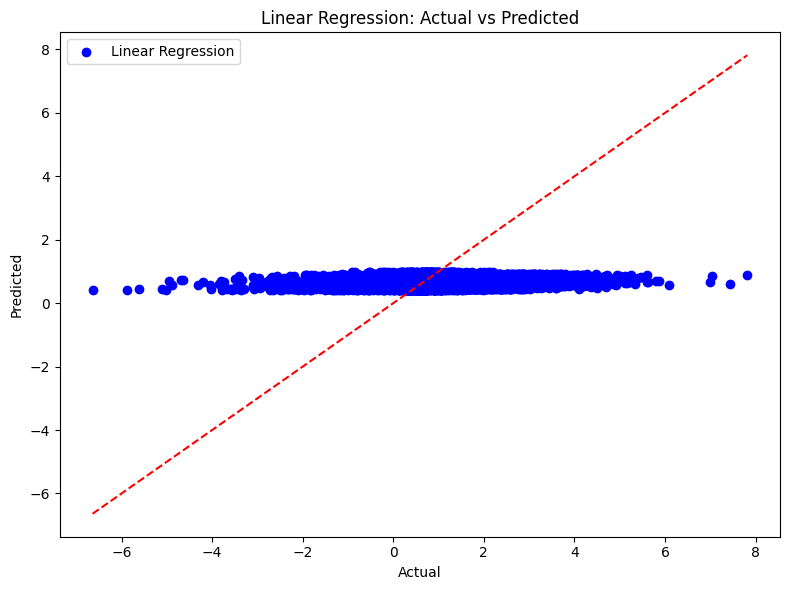

In [128]:
# Figure 9:

# Prediction vs Actual for Linear Regression
plt.figure(figsize=(8, 6))

# Create the scatter plot to compare actual vs predicted values
plt.scatter(y_test, y_pred, color='blue', label='Linear Regression')

# Add a diagonal line where predicted values equal actual values
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')

# Add title and labels
plt.title('Linear Regression: Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')

# Add a legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

The plot shows the actual vs predicted values for the Linear Regression model. The blue dots represent the individual data points, while the red dashed line represents the ideal scenario where the predicted values perfectly match the actual values. I can see that the predicted values are almost constant and do not align well with the actual values, as indicated by the scattered blue dots and the red dashed line. This suggests that the model is not capturing the underlying patterns in the data effectively, with a high level of bias. The model's predictions are consistently off, especially for higher actual values, highlighting its poor performance. Further improvements or more complex models may be needed.




**Figure 9:**

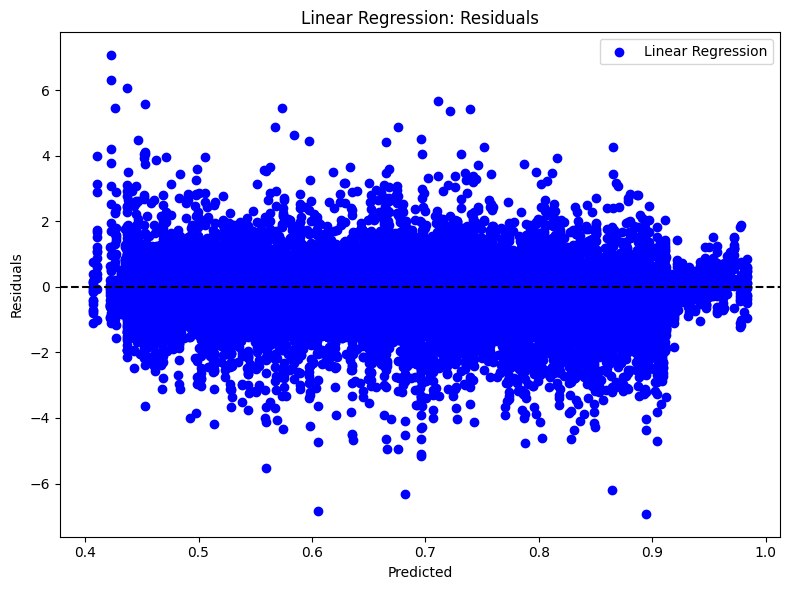

In [129]:
# Figure 10:

# Residuals for Linear Regression
plt.figure(figsize=(8, 6))

# Create the scatter plot of predicted vs residuals
plt.scatter(y_pred, y_pred - y_test, color='blue', label='Linear Regression')

# Add a horizontal line at 0 to show where residuals should ideally be centered
plt.axhline(0, color='black', linestyle='--')

# Add title and labels
plt.title('Linear Regression: Residuals')
plt.xlabel('Predicted')
plt.ylabel('Residuals')

# Add a legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

**Figure 10:**

The residuals plot for the Linear Regression model shows the difference between the predicted values and the actual values (residuals). The blue dots represent the residuals for each data point, while the dashed black line represents the baseline (residual = 0), where the predicted values perfectly match the actual values. I can see that the residuals are spread out along the predicted values, with no clear pattern, indicating that the model is not capturing certain aspects of the data. The residuals appear to be randomly scattered, which suggests that the linear model is not able to fully capture the relationships in the data, leading to significant prediction errors for many data points.

###Method 2: Gradient Boosting Regressor


In [130]:
# I first want to perform hyperparameter tuning to find the best parameters for the Gradient Boosting Regressor

# Define the model
gb_model = GradientBoostingRegressor(random_state=42)

# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 150],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 4],
    'min_samples_split': [2, 5],
    'subsample': [0.8, 1.0]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters and score
print("Best Parameters: ", grid_search.best_params_)
print("Best Cross-Validation Score: ", grid_search.best_score_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Parameters:  {'learning_rate': 0.1, 'max_depth': 4, 'min_samples_split': 2, 'n_estimators': 150, 'subsample': 0.8}
Best Cross-Validation Score:  0.11935846083375401


In the code above, I am doing hyperparameter tuning with GridSearchCV. This will help in performing an exhaustive search over a specified parameter grid, evaluating each combination using cross-validation to give me the best parameters for my dataset to use in the Gradient Boosting Regressor model.



In [131]:
# Initialize the Gradient Boosting Regressor with the best parameters from the previous code
gb_model = GradientBoostingRegressor(
    learning_rate=0.1,
    max_depth=4,
    min_samples_split=2,
    n_estimators=150,
    subsample=0.8,
    random_state=42
)

# Train the model on the standardized training data
gb_model.fit(X_train_scaled, y_train)

# Predict on the test data
y_pred_gb = gb_model.predict(X_test_scaled)

# Evaluate the model
mae_gb = mean_absolute_error(y_test, y_pred_gb)
mse_gb = mean_squared_error(y_test, y_pred_gb)
rmse_gb = np.sqrt(mse_gb)
r2_gb = r2_score(y_test, y_pred_gb)

# Print the evaluation metrics
print(f"Gradient Boosting Model - Mean Absolute Error (MAE): {mae_gb}")
print(f"Gradient Boosting Model - Mean Squared Error (MSE): {mse_gb}")
print(f"Gradient Boosting Model - Root Mean Squared Error (RMSE): {rmse_gb}")
print(f"Gradient Boosting Model - R-squared (R2): {r2_gb}")

Gradient Boosting Model - Mean Absolute Error (MAE): 0.6540901646308436
Gradient Boosting Model - Mean Squared Error (MSE): 0.835100762842041
Gradient Boosting Model - Root Mean Squared Error (RMSE): 0.9138384774357233
Gradient Boosting Model - R-squared (R2): -0.2182544575153249


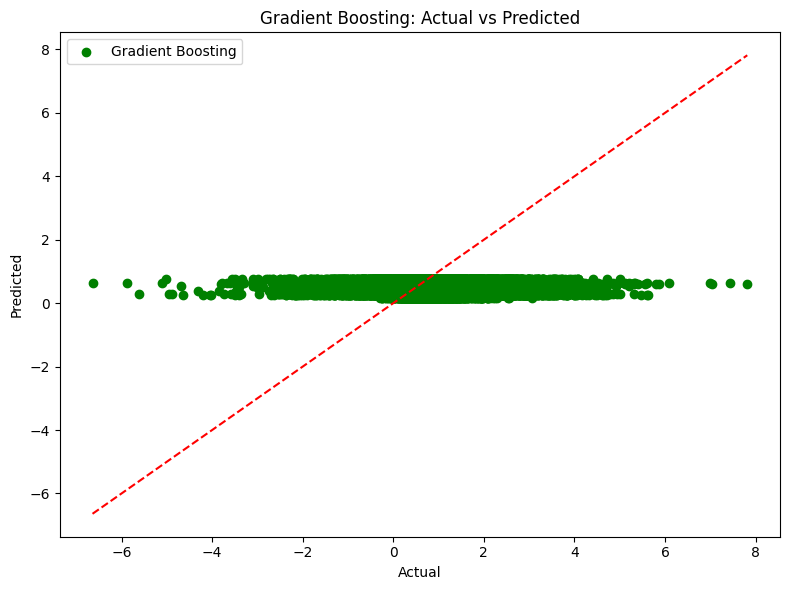

In [132]:
# Figure 11:

# Prediction vs Actual for Gradient Boosting
plt.figure(figsize=(8, 6))

# Create the scatter plot to compare actual vs predicted values
plt.scatter(y_test, y_pred_gb, color='green', label='Gradient Boosting')

# Add a diagonal line where predicted values equal actual values
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')

# Add title and labels
plt.title('Gradient Boosting: Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')

# Add a legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

**Figure 11:**

The plot shows the predicted vs actual values for the Gradient Boosting Regressor model. The green dots represent the individual data points, while the red dashed line represents the ideal scenario where the predicted values perfectly match the actual values. I can see that the predicted values are mostly concentrated around 0, with very little variation across the range of actual values. This suggests that the model is not capturing the underlying relationships in the data, as most predictions fall near zero regardless of the actual values.


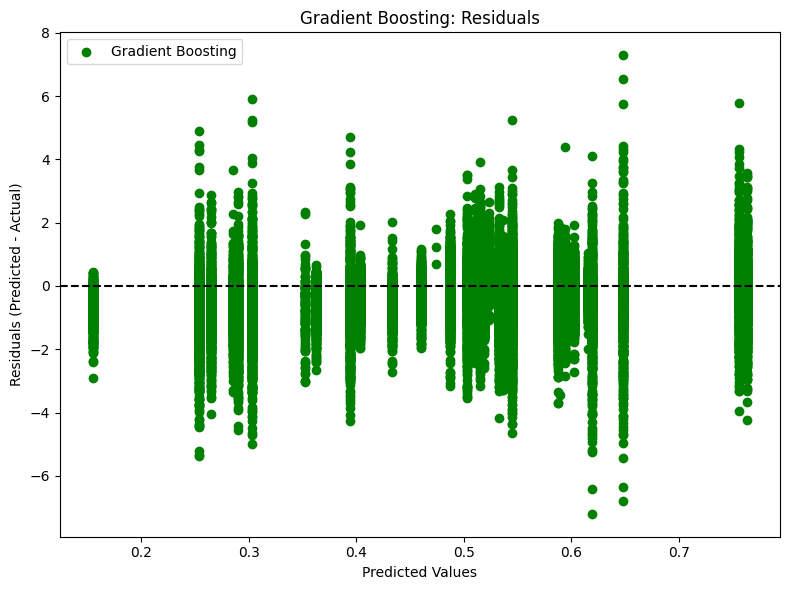

In [133]:
# Figure 12:

# Residuals for Gradient Boosting
plt.figure(figsize=(8, 6))

# Create the scatter plot of predicted vs residuals
plt.scatter(y_pred_gb, y_pred_gb - y_test, color='green', label='Gradient Boosting')

# Add a horizontal line at 0 to show where residuals should ideally be centered
plt.axhline(0, color='black', linestyle='--')

# Add title and labels
plt.title('Gradient Boosting: Residuals')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals (Predicted - Actual)')

# Add a legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

**Figure 12:**

The residual plot for the Gradient Boosting Regressor model shows the difference between the predicted values and the actual values (residuals). The green dots represent the residuals for each data point, while the dashed black line represents the baseline (residual = 0), where the predicted values perfectly match the actual values. I can see that the residuals are spread both above and below the baseline, with no clear pattern or trend. This suggests that the model is making predictions that are both over and under the true values, but without any systematic error. The scatter of residuals appears to be fairly uniform across the predicted values, indicating that the model does not exhibit significant bias in predicting different ranges of values. However, the presence of larger deviations in some areas suggests that the model is still struggling to capture certain aspects of the data.

###Method 3: Support Vector Machine Regression (SVR)

In [134]:
# Initialize the Support Vector Regressor model
svr_model = SVR(kernel='rbf')

# Train the model on the standardized training data
svr_model.fit(X_train_scaled, y_train)

# Predict on the test data
y_pred_svr = svr_model.predict(X_test_scaled)

# Evaluate the model
mae_svr = mean_absolute_error(y_test, y_pred_svr)
mse_svr = mean_squared_error(y_test, y_pred_svr)
rmse_svr = np.sqrt(mse_svr)
r2_svr = r2_score(y_test, y_pred_svr)

# Print the evaluation metrics
print(f"SVM Model - Mean Absolute Error (MAE): {mae_svr}")
print(f"SVM Model - Mean Squared Error (MSE): {mse_svr}")
print(f"SVM Model - Root Mean Squared Error (RMSE): {rmse_svr}")
print(f"SVM Model - R-squared (R2): {r2_svr}")

SVM Model - Mean Absolute Error (MAE): 0.8453263055931414
SVM Model - Mean Squared Error (MSE): 1.221451969784152
SVM Model - Root Mean Squared Error (RMSE): 1.10519318211078
SVM Model - R-squared (R2): -0.7818679769448122


I wanted to do some hyperparameter tuning for SVR. I tried doing
GridSearchCV, RandomizedSearchCV, and manual tuning, but they were all taking a very long time because the dataset is very big.


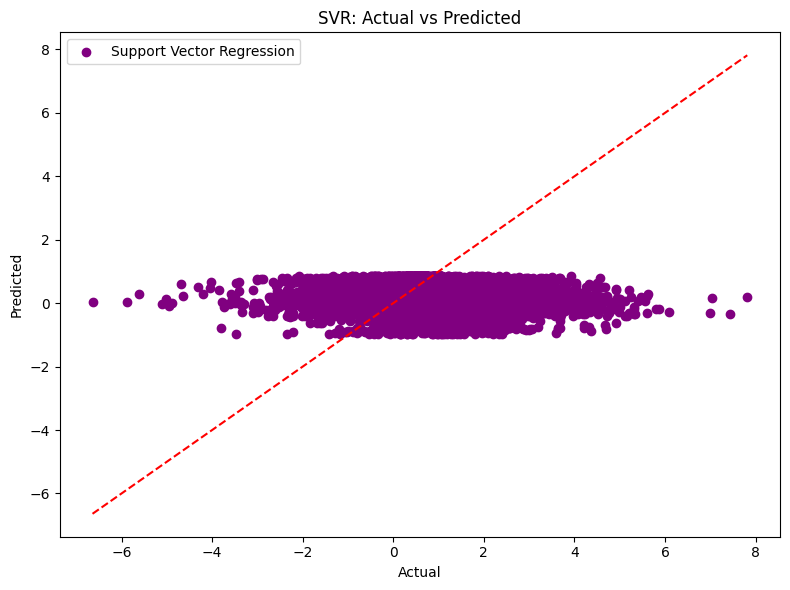

In [135]:
# Figure 13:

# Prediction vs Actual for SVR
plt.figure(figsize=(8, 6))

# Create the scatter plot to compare actual vs predicted values
plt.scatter(y_test, y_pred_svr, color='purple', label='Support Vector Regression')

# Add a diagonal line where predicted values equal actual values
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')

#Add title and labels
plt.title('SVR: Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')

# Add a legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

**Figure 13:**

The plot shows the predicted vs actual values for the Support Vector Machine Regression model. The purple dots represent the individual data points, while the red dashed line represents the ideal scenario where the predicted values perfectly match the actual values. I can see that the predicted values are mostly clustered around 0, with very few data points spread across the full range of actual values. This suggests that the model is failing to capture the variability in the data, as it is consistently predicting values close to zero, regardless of the actual values.

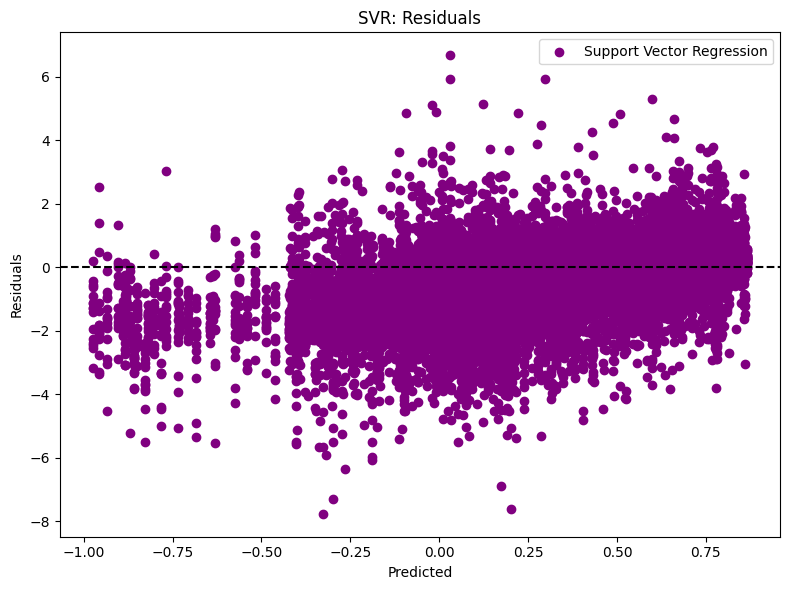

In [136]:
# Figure 14:

# Residuals for Support Vector Machine Regression
plt.figure(figsize=(8, 6))

# Create the scatter plot of predicted vs residuals
plt.scatter(y_pred_svr, y_pred_svr - y_test, color='purple', label='Support Vector Regression')

# Add a horizontal line at 0 to show where residuals should ideally be centered
plt.axhline(0, color='black', linestyle='--')

# Add title and labels
plt.title('SVR: Residuals')
plt.xlabel('Predicted')
plt.ylabel('Residuals')

# Add a legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

**Figure 14:**

The residual plot for the Support Vector Machine Regression model shows the difference between the predicted values and the actual values (residuals). The purple dots represent the residuals for each data point, while the dashed black line represents the baseline (residual = 0), where the predicted values perfectly match the actual values. I can see that the residuals are widely scattered around the baseline (0), both above and below the line. This suggests that the model is producing errors that are not systematically biased, as the residuals appear to be distributed evenly in both directions.


###Comparing the three methds

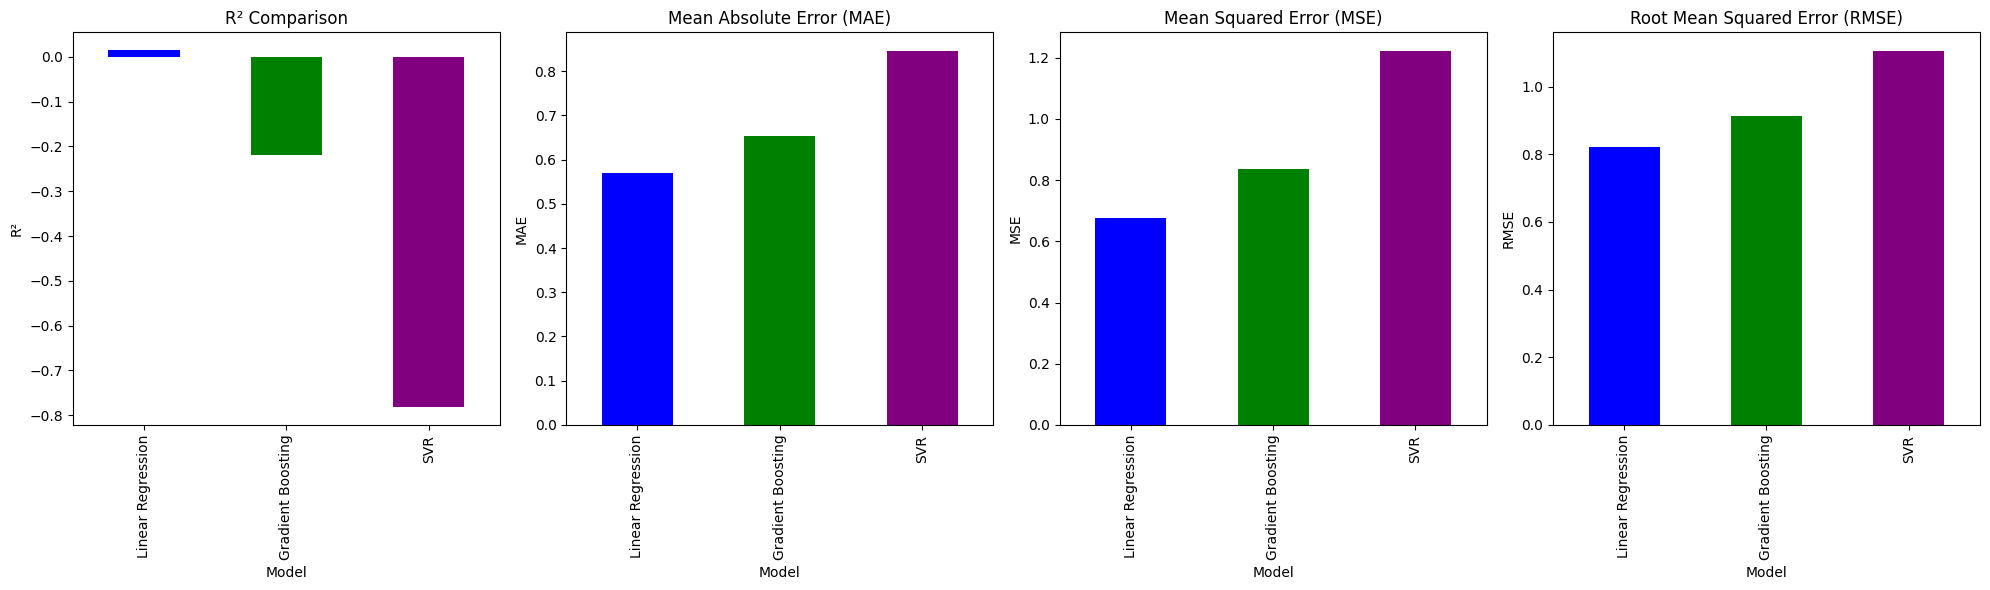

In [137]:
# Figure 15:

# Store the evaluation metrics for each model
metrics = {
    'Linear Regression': {'R²': r2, 'MAE': mae, 'MSE': mse, 'RMSE': rmse},
    'Gradient Boosting': {'R²': r2_gb, 'MAE': mae_gb, 'MSE': mse_gb, 'RMSE': rmse_gb},
    'SVR': {'R²': r2_svr, 'MAE': mae_svr, 'MSE': mse_svr, 'RMSE': rmse_svr},
}

# Create a DataFrame to make plotting easier
metrics_df = pd.DataFrame(metrics)

# Plot the comparison for each metric
fig, axes = plt.subplots(1, 4, figsize=(20, 6))

# Plot for R²
metrics_df.loc['R²'].plot(kind='bar', ax=axes[0], color=['blue', 'green', 'purple'])
axes[0].set_title('R² Comparison')
axes[0].set_ylabel('R²')
axes[0].set_xlabel('Model')

# Plot for MAE
metrics_df.loc['MAE'].plot(kind='bar', ax=axes[1], color=['blue', 'green', 'purple'])
axes[1].set_title('Mean Absolute Error (MAE)')
axes[1].set_ylabel('MAE')
axes[1].set_xlabel('Model')

# Plot for MSE
metrics_df.loc['MSE'].plot(kind='bar', ax=axes[2], color=['blue', 'green', 'purple'])
axes[2].set_title('Mean Squared Error (MSE)')
axes[2].set_ylabel('MSE')
axes[2].set_xlabel('Model')

# Plot for RMSE
metrics_df.loc['RMSE'].plot(kind='bar', ax=axes[3], color=['blue', 'green', 'purple'])
axes[3].set_title('Root Mean Squared Error (RMSE)')
axes[3].set_ylabel('RMSE')
axes[3].set_xlabel('Model')

# Show the plots
plt.tight_layout()
plt.show()

**Figure 15:**

The comparison plot visualizes the performance of three models I performed, Linear Regression, Gradient Boosting, and SVR, across four evaluation metrics: R², Mean Absolute Error (MAE), Mean Squared Error (MSE), and Root Mean Squared Error (RMSE).

- R² Comparison: The SVR model has the highest R², suggesting it explains more variance in the data than both Linear Regression and Gradient Boosting. However, the R² score is still relatively low for all models, indicating that none of the models is a perfect fit for the data.

- MAE, MSE, and RMSE Comparison: The SVR model has the highest error metrics (MAE, MSE, and RMSE), suggesting that its predictions are farther from the actual values compared to Linear Regression and Gradient Boosting. Linear Regression performs slightly worse than Gradient Boosting in terms of errors, but overall, all models could benefit from further tuning or more advanced techniques to improve their predictive performance.

Overall, this plot highlights that Gradient Boosting might be the most balanced model in terms of performance, offering moderate predictive power with relatively lower errors.

##Questions:

**1- Which method did you like the most?**

The method I liked the most is the Gradient Boosting, because it is known to have strong performance on complex datasets since it can capture non-linear relationships and handle interactions between features better than Linear Regression and SVR. Also, from the comparison metrics (like R², MAE, MSE, and RMSE), Gradient Boosting offers balanced performance, although not the best, but better than Linear Regression and SVR. It balances accuracy and error metrics more effectively.

**2- Which method did you like the least?**

The method I liked the least is the Support Vector Regression (SVR), because it is known that SVR might struggle with datasets where the relationships are not easily separable by a hyperplane (non-linear patterns), which is likely the case with this dataset. Also, SVR showed the highest MAE, MSE, and RMSE values compared to Linear Regression and Gradient Boosting, suggesting that its predictions were further off from the actual values. In addition, I was not able to do some hyperparameter tuning for SVR because it was taking very long to generate the code due to the large dataset.



**3- How did you score these supervised models?**

I scored each of the models using evaluation metrics (R², MAE, MSE, and RMSE) and their general performance in the project.
- R²: Measures the proportion of variance in the dependent variable that is explained by the model. It ranges from 0 to 1, with 1 indicating perfect predictions.
- MAE: Measures the average absolute difference between the predicted and actual values. It gives an idea of the magnitude of the prediction error. A lower MAE means that the model’s predictions are closer to the actual values.
- MSE: Measures the average squared difference between the predicted and actual values. Larger errors are penalized more due to the squaring. A lower MSE indicates better model performance.
-RMSE: Measures the square root of MSE, which brings it back to the same units as the target variable. A lower RMSE is better, as it indicates smaller deviations between predicted and actual values.

As such, I used these metrics to see which model explained the most variance (using R²),which model had the smallest errors (using MAE and RMSE), Which model’s errors were penalized the most (using MSE). Also, what helped me visualize the results was the prediction vs actual plots and the residual plots.


**4- Did the output align with your geologic understanding?**

The outputs from Linear Regression, Gradient Boosting, and SVR provide a solid starting point, but based on the model performance and residuals, it seems the models did not perform very well and failed to achieve high accuracy. Temperature change is influenced by multiple interconnected geological and environmental factors, and models like Gradient Boosting or SVR should ideally capture these complexities. However, the models' limited performance could be due to the absence of important underlying factors, such as altitude, regional temperature patterns, or external influences like volcanic activity or human impacts. These factors might be crucial for more accurate predictions of temperature variations.






**5- What did you want to learn more about?**

I would like to dive deeper into the methods I used and understand when to prioritize one over the other. I am also interested in how different models capture interactions between features and how these interactions influence the results. Additionally, I would like to explore the computational demands of models like SVR, particularly how large datasets affect training times and how to handle these challenges. I am also curious about how models might overfit or underfit the data, and understanding which models or techniques are best suited to minimize these issues. Finally, I want to explore whether the similarity in results across the models I used is due to the nature of the dataset, user error, or if these methods naturally produce similar outputs.

**6- Did you pre-process your data? Do all models require pre-processing?**


Yes, I did a lot of pre-processing to the dataset Like:

- Cleaning the dataset: Removing missing or irrelevant data.
- Normalizing and scaling the data: This step was essential for the supervised learning models since some of them are sensitive to the scale of the data.
- Splitting the data by performing both temporal and spatial splits to ensure the data was split into training and testing sets that were independent, preventing data leakage and autocorrelation, which could negatively affect model performance.

Not all models require the same level of pre-processing, but most models benefit from it. Models like SVR are highly sensitive to the scale of features and require feature scaling to perform well. Linear Regression and Gradient Boosting are less sensitive to scaling but still benefit from handling missing values and removing outliers. Overall, while the extent of preprocessing may vary, it's crucial for improving model performance and ensuring the data is in the best format for training.